### Setup

In [1]:
# !pip install -q scikit-learn numpy pandas matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Models we’ll use
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline
np.random.seed(1)


### Load Data

In [2]:
# Start from raw and create normalised features Xs (as the lab expects)
raw = pd.read_csv("/content/WDBC.csv")  # upload first
# Drop ID if present (case-insensitive)
id_cols = [c for c in raw.columns if c.lower() == "id"]
if id_cols:
  raw = raw.drop(columns=id_cols)
  # Encode labels
raw["Diagnosis"] = raw["Diagnosis"].replace({"M":1, "B":0, "malignant":1, "benign":0})
y = raw["Diagnosis"].astype(int).values
X = raw.drop(columns=["Diagnosis"]).values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
print("Xs shape:", Xs.shape, "y shape:", y.shape)


Xs shape: (569, 30) y shape: (569,)


/tmp/ipython-input-642771729.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw["Diagnosis"] = raw["Diagnosis"].replace({"M":1, "B":0, "malignant":1, "benign":0})


### K Fold cross validation (With SVM)

In [3]:
n_folds = 5
clf_cv = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', probability=True)
scores = cross_val_score(clf_cv, Xs, y, cv=n_folds)

print("Fold scores:", scores)
avg = (100*np.mean(scores), 100*np.std(scores)/np.sqrt(scores.shape[0]))
print("Average score and standard deviation: (%.2f ± %.3f)%%" % avg)


Fold scores: [0.97368421 0.95614035 1.         0.96491228 0.97345133]
Average score and standard deviation: (97.36 ± 0.656)%


In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
fold_acc = []
for tr, te in kf.split(Xs, y):
    svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', probability=True)
    svm.fit(Xs[tr], y[tr])
    acc = svm.score(Xs[te], y[te])
    fold_acc.append(acc)
    print(f"Fold accuracy: {acc:0.2f}")
print("Mean accuracy:", np.mean(fold_acc))


Fold accuracy: 0.97
Fold accuracy: 0.96
Fold accuracy: 0.96
Fold accuracy: 0.97
Fold accuracy: 0.97
Mean accuracy: 0.9666200900481291


### Evaluation metrics

#### Train Test Split

In [5]:
Xs_train, Xs_test, y_train, y_test = train_test_split(
    Xs, y, test_size=0.30, random_state=1, stratify=y
)


#### Fit SVM, confusion matrix and metrics

Confusion matrix:
 [[105   2]
 [  6  58]]


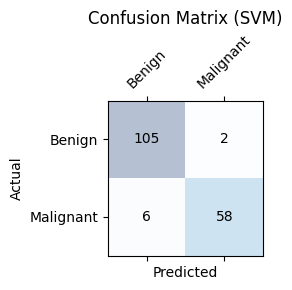

              precision    recall  f1-score   support

      Benign       0.95      0.98      0.96       107
   Malignant       0.97      0.91      0.94        64

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



In [6]:
svm_clf = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', probability=True)
y_pred = svm_clf.fit(Xs_train, y_train).predict(Xs_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Pretty plot
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes = ["Benign","Malignant"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=classes))


### ROC/ AUC

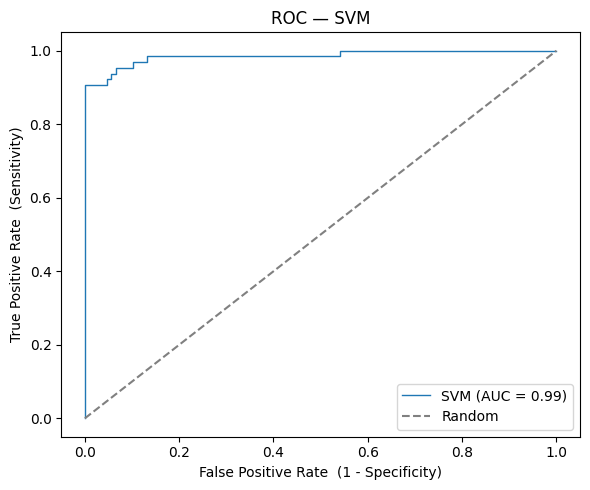

In [7]:
probas_ = svm_clf.predict_proba(Xs_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probas_)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=1, label=f"SVM (AUC = {roc_auc:0.2f})")
plt.plot([0,1], [0,1], '--', color='gray', label='Random')
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate  (1 - Specificity)')
plt.ylabel('True Positive Rate  (Sensitivity)')
plt.title('ROC — SVM')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


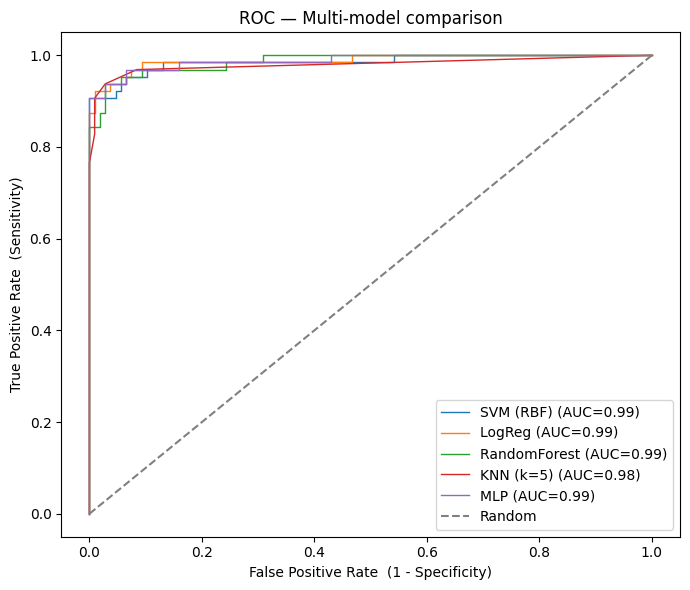

In [8]:
models = {
    "SVM (RBF)": SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', probability=True, random_state=1),
    "LogReg": LogisticRegression(max_iter=200, random_state=1),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_leaf_nodes=16, random_state=1),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=400, random_state=1),
}

plt.figure(figsize=(7,6))
for name, model in models.items():
    model.fit(Xs_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xs_test)[:, 1]
    else:
        # safety: some SVM configs use decision_function
        y_score = model.decision_function(Xs_test)
        # map to [0,1] via min-max for ROC (not needed if probability=True)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min() + 1e-9)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f"{name} (AUC={roc_auc:0.2f})")

plt.plot([0,1], [0,1], '--', color='gray', label='Random')
plt.xlim([-0.05,1.05]); plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate  (1 - Specificity)')
plt.ylabel('True Positive Rate  (Sensitivity)')
plt.title('ROC — Multi‑model comparison')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
